In [1]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import pandas as pd
import xarray as xr
from sklearn.preprocessing import scale
import scipy
from scipy.special import expit
import pytensor.tensor as pt

In [3]:
grants = pd.read_csv('Data/NWOGrants.csv',sep=';')
grants.head()

,discipline,gender,applications,awards
0,Chemical sciences,m,83,22
1,Chemical sciences,f,39,10
2,Physical sciences,m,135,26
3,Physical sciences,f,39,9
4,Physics,m,67,18


([<matplotlib.axis.XTick at 0x15ed8bfd550>,
 [Text(0, 0, 'Chemical sciences'),
  Text(1, 0, 'Chemical sciences'),
  Text(2, 0, 'Physical sciences'),
  Text(3, 0, 'Physical sciences'),
  Text(4, 0, 'Physics'),
  Text(5, 0, 'Physics'),
  Text(6, 0, 'Humanities'),
  Text(7, 0, 'Humanities'),
  Text(8, 0, 'Technical sciences'),
  Text(9, 0, 'Technical sciences'),
  Text(10, 0, 'Interdisciplinary'),
  Text(11, 0, 'Interdisciplinary'),
  Text(12, 0, 'Earth/life sciences'),
  Text(13, 0, 'Earth/life sciences'),
  Text(14, 0, 'Social sciences'),
  Text(15, 0, 'Social sciences'),
  Text(16, 0, 'Medical sciences'),
  Text(17, 0, 'Medical sciences')])

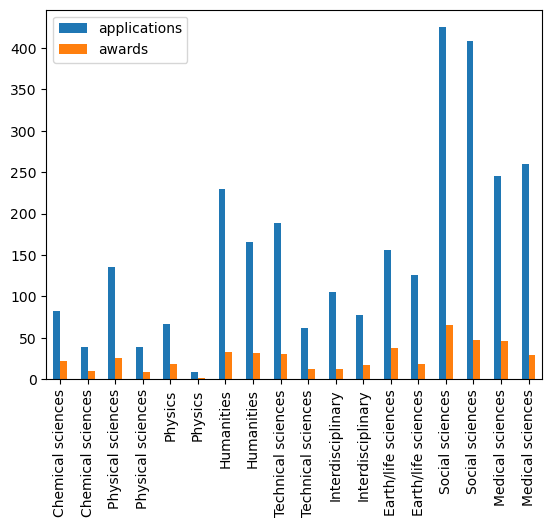

In [21]:
#bars =plt.bar(x=grants['discipline'],height=grants['applications'],color=np.where(grants['gender']=='m', 'green','orange'))
#plt.bar(x=grants['discipline'],height=grants['awards'])
#plt.legend(bars,['Male','Female'])
#plt.xticks(rotation=45)
grants.plot(kind='bar',stacked=False,)
plt.xticks(grants.index,grants['discipline'])


In [22]:
grants.head()

,discipline,gender,applications,awards
0,Chemical sciences,m,83,22
1,Chemical sciences,f,39,10
2,Physical sciences,m,135,26
3,Physical sciences,f,39,9
4,Physics,m,67,18


In [35]:
Didx,discipline = grants['discipline'].factorize()
Gidx,gender     = grants['gender'].factorize()
coords = {'discipline':discipline,'gender':gender}


In [121]:
gender

Index(['m', 'f'], dtype='object')

In [48]:
# We have Discipline (D), Gender (G), Applications (A) and Awards (Aw) as some percentage of applications
# Only need to condition on Gender

with pm.Model(coords=coords) as grants_m:
    D = pm.MutableData("D",Didx)
    G = pm.MutableData("G",Gidx)
    a = pm.Normal('a',-1,1,dims='gender')
    A = a[G]
    
    Award = pm.Binomial('Award',n=grants['applications'],logit_p=A,observed = grants['awards'])
    total_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


In [49]:
az.summary(total_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[m],-1.535,0.064,-1.656,-1.417,0.001,0.001,3910.0,2970.0,1.0
a[f],-1.740,0.081,-1.884,-1.583,0.001,0.001,4192.0,3009.0,1.0


<AxesSubplot: >

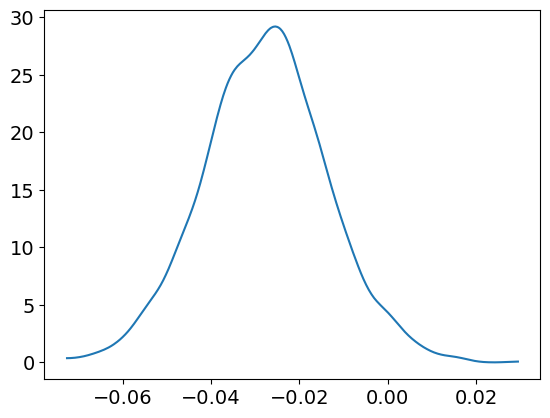

In [67]:
gender_contrast = expit(total_trace.posterior.a[:,:,1]) - expit(total_trace.posterior.a[:,:,0])
az.plot_dist(gender_contrast)

In [92]:
with pm.Model(coords=coords) as direct_m:
    D = pm.MutableData("D",Didx)
    G = pm.MutableData("G",Gidx)
    a = pm.Normal('a',-1,1,dims=['gender','discipline'])
    A = a[G,D]
    
    Award = pm.Binomial('Award',n=grants['applications'],logit_p=A,observed = grants['awards'])
    direct_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


In [93]:
az.summary(direct_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"a[m, Chemical sciences]",-1.036,0.243,-1.481,-0.564,0.003,0.002,7820.0,3083.0,1.00
"a[m, Physical sciences]",-1.424,0.213,-1.815,-1.009,0.002,0.002,8863.0,2430.0,1.00
"a[m, Physics]",-1.011,0.270,-1.530,-0.510,0.003,0.002,7816.0,2807.0,1.00
"a[m, Humanities]",-1.772,0.177,-2.115,-1.458,0.002,0.001,9055.0,3073.0,1.00
"a[m, Technical sciences]",-1.652,0.191,-1.987,-1.269,0.002,0.001,8506.0,3202.0,1.00
"a[m, Interdisciplinary]",-1.994,0.281,-2.547,-1.490,0.003,0.002,7151.0,3083.0,1.00
"a[m, Earth/life sciences]",-1.136,0.183,-1.471,-0.794,0.002,0.001,9718.0,2956.0,1.00
"a[m, Social sciences]",-1.708,0.130,-1.963,-1.474,0.002,0.001,7536.0,2977.0,1.00
"a[m, Medical sciences]",-1.460,0.160,-1.749,-1.166,0.002,0.001,8816.0,2710.0,1.00
"a[f, Chemical sciences]",-1.082,0.346,-1.738,-0.438,0.004,0.003,7505.0,3178.0,1.00


In [94]:
direct_post = expit(direct_trace.posterior)
direct_contrast = direct_post.a[:,:,1,:] - direct_post.a[:,:,0,:]

In [95]:
direct_contrast

<xarray.DataArray 'a' (chain: 4, draw: 1000, discipline: 9)>
array([[[ 0.01622703,  0.0538197 , -0.19569222, ..., -0.07172296,
         -0.0667113 , -0.11441414],
        [ 0.04469698,  0.04787788, -0.15359498, ..., -0.04636631,
         -0.0748499 , -0.08321284],
        [-0.05964727,  0.00994135,  0.18977029, ..., -0.13023387,
          0.00441241, -0.06894202],
        ...,
        [ 0.00853563, -0.00318692, -0.01381659, ..., -0.09231762,
         -0.03751307, -0.03457794],
        [ 0.05323062,  0.00073328, -0.08830349, ..., -0.10468542,
         -0.05832439, -0.03283864],
        [-0.0774728 ,  0.07661975,  0.01734412, ..., -0.08578591,
         -0.01815695, -0.10822244]],

       [[ 0.10489238, -0.01295675,  0.2546475 , ..., -0.07093568,
         -0.02265675, -0.0878949 ],
        [ 0.02759923,  0.01909888, -0.29321822, ..., -0.11727139,
         -0.05912162, -0.06348912],
        [ 0.02973355, -0.03915844, -0.12905809, ..., -0.15038494,
         -0.06493933, -0.09127672],
...
        [-0.01613157,  0.26966806, -0.05000737, ..., -0.10502877,
         -0.04100637, -0.05893192],
        [-0.0265765 , -0.03103768,  0.01933485, ..., -0.14495451,
         -0.02729587, -0.06302344],
        [-0.0936316 ,  0.16061718,  0.09488454, ..., -0.10462209,
         -0.04816126, -0.0654264 ]],

       [[-0.0071507 , -0.03608297, -0.21725   , ..., -0.04296506,
         -0.03685081, -0.09066294],
        [-0.00465952,  0.07533796,  0.04908783, ..., -0.1179938 ,
         -0.05975747, -0.0217256 ],
        [-0.01355923, -0.05203957,  0.0128785 , ..., -0.10505074,
         -0.03114304, -0.11946925],
        ...,
        [-0.05723845, -0.00809202, -0.12409269, ..., -0.17687334,
         -0.03946423, -0.06320796],
        [-0.02417863,  0.00616068, -0.11364277, ..., -0.19343424,
          0.02223701, -0.07233987],
        [-0.02478212,  0.10040969, -0.00703011, ...,  0.04359118,
         -0.09849677, -0.08471459]]])
Coordinates:
  * chain       (chain) int32 0 1 2 3
  * draw        (draw) int32 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * discipline  (discipline) <U19 'Chemical sciences' ... 'Medical sciences'

array([[<AxesSubplot: title={'center': 'a\nChemical sciences'}>,
        <AxesSubplot: title={'center': 'a\nPhysical sciences'}>,
        <AxesSubplot: title={'center': 'a\nPhysics'}>],
       [<AxesSubplot: title={'center': 'a\nHumanities'}>,
        <AxesSubplot: title={'center': 'a\nTechnical sciences'}>,
        <AxesSubplot: title={'center': 'a\nInterdisciplinary'}>],
       [<AxesSubplot: title={'center': 'a\nEarth/life sciences'}>,
        <AxesSubplot: title={'center': 'a\nSocial sciences'}>,
        <AxesSubplot: title={'center': 'a\nMedical sciences'}>]],
      dtype=object)

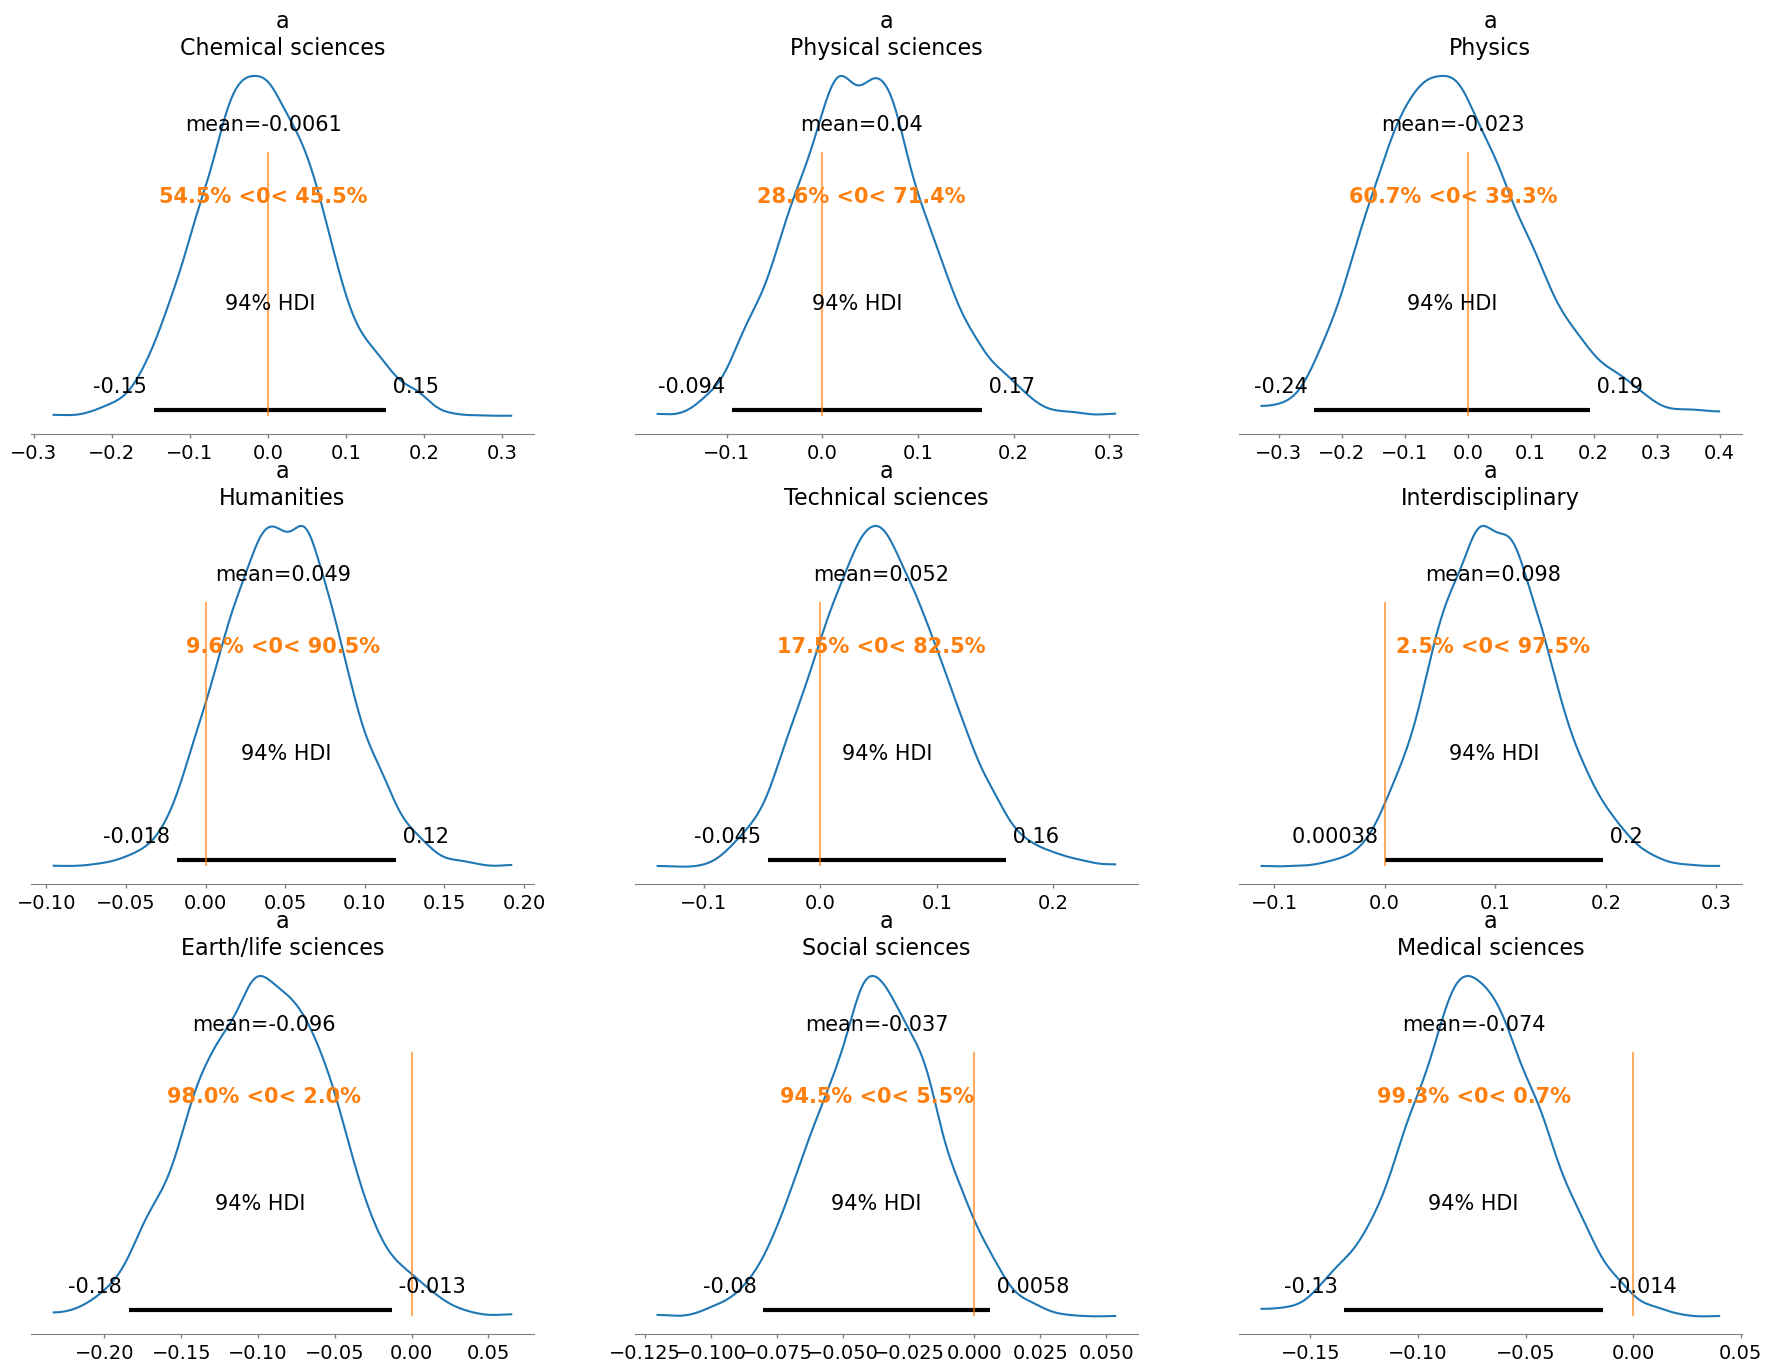

In [96]:
az.plot_posterior(direct_contrast,ref_val=0.0)
#direct_contrast

In [97]:
with direct_m:
    post_p = pm.sample_posterior_predictive(direct_trace)

Sampling: [Award]


In [122]:
direct_trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

In [125]:
with direct_m:
    pm.set_data({
        'G' : np.where(gender == 'm')[0]
    })
    
    m_pred = pm.sample_posterior_predictive(direct_trace)

Sampling: [Award]


In [126]:
m_pred

Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

In [127]:
with direct_m:
    pm.set_data({
        'G' : np.where(gender== 'f')[0]
    })
    
    f_pred= pm.sample_posterior_predictive(direct_trace)

Sampling: [Award]


In [128]:
f_pred

Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

In [141]:
m_pred_flat = m_pred.posterior_predictive.Award.values.flatten()
f_pred_flat = f_pred.posterior_predictive.Award.values.flatten()

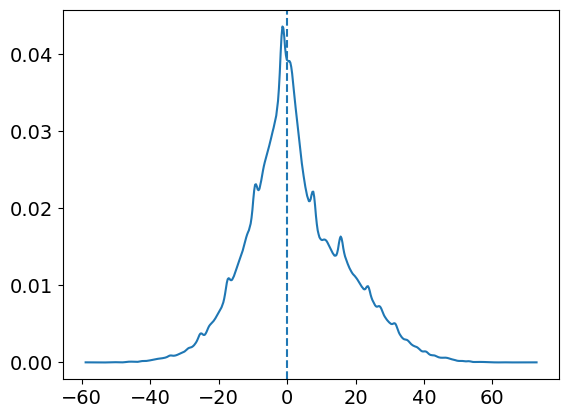

In [167]:
contrast = m_pred_flat - f_pred_flat
az.plot_kde(contrast)
plt.axvline(x=0,linestyle='--')

In [174]:
#Question 5 
UFC = pd.read_csv('Data/UFClefties.csv',sep=';')
UFC.head()

,fight,episode,fight.in.episode,fighter1.win,fighter1,fighter2,fighter1.lefty,fighter2.lefty
0,1181,118,1,0,146,175,1,1
1,1182,118,2,0,133,91,1,0
2,1183,118,3,1,56,147,1,0
3,1184,118,4,1,192,104,0,0
4,1185,118,5,1,79,15,0,0


In [175]:
UFC.shape

(205, 8)

In [177]:
with pm.Model() as ufc_m:
    f1_lefty = pm.MutableData('f1_lefty',UFC['fighter1.lefty'].values)
    f2_lefty = pm.MutableData('f2_lefty',UFC['fighter2.lefty'].values)
    f1_win   = pm.MutableData('f1_win',  UFC['fighter1.win'].values)
    f1       = pm.MutableData('f1', UFC['fighter1'].values)
    f2       = pm.MutableData('f2', UFC['fighter2'].values)
    
    a1 = pm.Normal('a1',0,1)
    a2 = pm.Normal('a2',0,1)
    f1B = pm.Normal('f1B',0,1)
    f2B = pm.Normal('f2B',0,1)
    p = (a1 + f1B*f1_lefty) - (a2 + f2B*f2_lefty)
    
    f1_win_obs = pm.Bernoulli('f1_win_obs',logit_p = p,observed=f1_win)
    
    ufc_trace = pm.sample()
    
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1, a2, f1B, f2B]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


In [178]:
az.summary(ufc_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a1,0.080,0.740,-1.290,1.461,0.019,0.014,1500.0,1618.0,1.0
a2,-0.141,0.734,-1.586,1.155,0.019,0.013,1517.0,1714.0,1.0
f1B,-0.297,0.315,-0.880,0.301,0.006,0.005,3161.0,2329.0,1.0
f2B,0.303,0.331,-0.320,0.929,0.006,0.005,3051.0,2211.0,1.0


In [180]:
with pm.Model() as ufc2_m:
    f1_lefty = pm.MutableData('f1_lefty',UFC['fighter1.lefty'].values)
    f2_lefty = pm.MutableData('f2_lefty',UFC['fighter2.lefty'].values)
    f1_win   = pm.MutableData('f1_win',  UFC['fighter1.win'].values)
    f1       = pm.MutableData('f1', UFC['fighter1'].values)
    f2       = pm.MutableData('f2', UFC['fighter2'].values)
    
    a1 = pm.Normal('a1',0,1)
    #a2 = pm.Normal('a2',0,1)
    #f1B = pm.Normal('f1B',0,1)
    #f2B = pm.Normal('f2B',0,1)
    p = a1*(f1 - f2)
    
    f1_win_obs = pm.Bernoulli('f1_win_obs',logit_p = p,observed=f1_win)
    
    ufc2_trace = pm.sample()
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


<AxesSubplot: title={'center': 'a1'}>

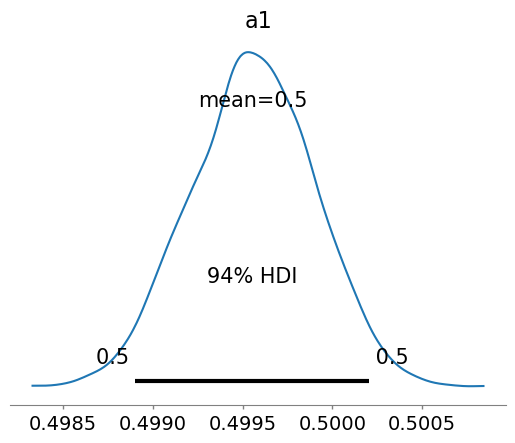

In [185]:
az.plot_posterior(expit(ufc2_trace.posterior.a1))

In [182]:
ufc2_trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data